## Het U-net 

**The installations of necessary packages on the virtual machine.**

In [4]:
# !pip install nibabel
# !pip install medpy

**The necessary imports of the packages that are used during the program.**

In [130]:
import os
import glob
import monai
from PIL import Image
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from skimage.segmentation import active_contour, find_boundaries, flood_fill
from scipy.ndimage import binary_fill_holes, binary_closing
from torchvision.utils import save_image

**The definition of the location of the database of ACDC and verification of the datapath location.**

In [2]:
data_path = "./preprocessed_ROI_TV005_v3/"
if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "testing"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain training and testing folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


**A modification of the build dictonary function of the tutorials to make sure the ACDC database can be allocated on the right place.**

In [60]:
# print(img.header.structarr['pixdim'])

def build_dict_ACDC(data_path, mode='training', heart_mode='Off'):
    """
    This functioprintn returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'training', 'val' or 'testing'.
        ----heart_mode-----
        Off: 1 dictionary of ED and ES together
        On: 2 separate ED and ES dictionaries
        secret: 1 dictionary of secret test set
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "val", "testing", "secret"]:
        raise ValueError(f"Please choose a mode in ['training', 'val', 'testing', 'secret']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    dicts2 = []
    paths_mri = []
    iBegin = 1
    iEnd = 101
    
    if (mode=='testing'):
        iBegin = 101
        iEnd = 151
        
    if (mode=='secret'):
        iBegin = 151
        iEnd = 176
        
    for i in tqdm(range(iBegin,iEnd)):
    # list all .png files in directory, including the path
        paths_mri.append(glob.glob(os.path.join(data_path, mode, 'patient{:03}'.format(i), '*[!gt].png')))
        
        # make a corresponding list for all the mask files
        for mri_path in paths_mri[0]:
            if (heart_mode=='secret'):
                dicts.append({'img': mri_path})
            mask_path = os.path.join(mri_path[0:-4]+'_gt'+ '.png')
            
            if os.path.exists(mask_path):
                if (heart_mode=='Off'):
                    dicts.append({'img': mri_path, 'mask': mask_path})
                else:
                    if 'ED' in mri_path:
                        dicts.append({'img': mri_path, 'mask': mask_path})
                    else:
                        dicts2.append({'img': mri_path, 'mask': mask_path})
            paths_mri.clear()
    if (heart_mode=='Off' or heart_mode=='secret'):
        return sorted(dicts, key=lambda d: d['img'])
    else:
        return sorted(dicts, key=lambda d: d['img']), sorted(dicts2, key=lambda d: d['img'])

dicts = build_dict_ACDC(data_path, mode='testing', heart_mode="Off")
print(f'{len(dicts)}')

100%|██████████| 50/50 [00:01<00:00, 48.23it/s]

1076


**A modification of the LoadTranform function to make sure that only the image data is used in the DL model.**

Some things are commented out for adaptation purposes later in the project

In [61]:
class LoadMriData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = Image.open(sample['img']).convert('L') # import as grayscale image
        # image = nib.load(sample['img']).get_fdata()
        image = np.array(image, dtype=np.uint8)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        
        # mask = nib.load(sample['mask']).get_fdata()
        mask = np.array(mask, dtype=np.uint8)
        
        # mask has value 255, 170 and 85 on the different classes, put them to multi-binary
        # mask[np.logical_and(mask>170,mask<255)]=1
        # mask[np.logical_and(mask>0,mask<85)]=2
        # mask[np.logical_and(mask>85,mask<170)]=3
        
        mask[np.where(mask==255)] = 1
        mask[np.where(mask==85)] = 2
        mask[np.where(mask==170)] = 3
        # mask[np.where(mask>0 & mask <255)] = 0.5
        return {'img': image, 'mask': mask, 'img_meta_dict': {'affine': np.eye(2)},
                'mask_meta_dict': {'affine': np.eye(2)}}

**A function, modified from tutorials, to visualize the images together with their masks.**

In [5]:
def visualize_mri_sample(sample, title=None):
# Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    
    plt.figure(figsize=[10,7])

    mask1 = np.where(mask==1,1,0)
    mask2 = np.where(mask==2,1,0)
    mask3= np.where(mask==3,1,0)
    overlay_mask1 = np.ma.masked_where(mask1 == 0, mask1 == 1)
    overlay_mask2 = np.ma.masked_where(mask2 == 0, mask2 == 1)
    overlay_mask3 = np.ma.masked_where(mask3 == 0, mask3 == 1)
    plt.imshow(image, 'gray')
    plt.imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask3, 'Purples', alpha = 0.7, clim=[0,1], interpolation='nearest')

    if title is not None:
        plt.title(title)
    plt.show()
    
    plt.figure(figsize=[10,7])
    plt.imshow(image, 'gray')
    if title is not None:
        plt.title(f'{title} without masks')
    plt.show()

In [6]:
# RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
# RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),

basic_transform = monai.transforms.Compose([LoadMriData(),
                                                monai.transforms.AddChanneld(keys=['img', 'mask']),
                                                monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
                                                monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1/2, spatial_axis=1),
                                                ])


composed_transform = monai.transforms.Compose([LoadMriData(),
                                               monai.transforms.AddChanneld(keys=['img', 'mask']),
                                               monai.transforms.NormalizeIntensityd(keys='img'),
                                               monai.transforms.RandFlipd(keys=['img', 'mask'], prob=1/2, spatial_axis=1),
                                               monai.transforms.RandRotated(keys=['img', 'mask'], prob=1/2, range_x=np.pi/6, mode=['bilinear','nearest']),
                                               monai.transforms.RandScaleIntensityd(keys='img', factors=0.1, prob=1.0),
                                               monai.transforms.RandShiftIntensityd(keys='img', offsets=0.1, prob=1.0),
                                                ])

/home/jovyan/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [7]:
def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    /!\ Random seed is not saved, then reproducibility is not enabled.
    """
    from copy import deepcopy
        
    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")
    
    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))
        
        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list

def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """
    
    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")
    
    pre_compose_list = list()
    
    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")
        
        try:
            transform = transform_dict['class'](**transform_dict['kwargs'])
        except TypeError: # Classes have been converted to str after saving
            transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])
            
        pre_compose_list.append(transform)
        
    return monai.transforms.Compose(pre_compose_list)

**Testing the function whether they perform as intended.**

In [11]:
data_path = "./preprocessed_ROI_v3/"
train_dict_list = build_dict_ACDC(data_path)
train_dataset = monai.data.CacheDataset(train_dict_list, transform=composed_transform)

val_dict_list = build_dict_ACDC(data_path, mode='testing')
val_dataset = monai.data.CacheDataset(val_dict_list, transform=test_transform)

Loading dataset: 100%|██████████| 1076/1076 [00:04<00:00, 224.45it/s]


[0 1 2 3]


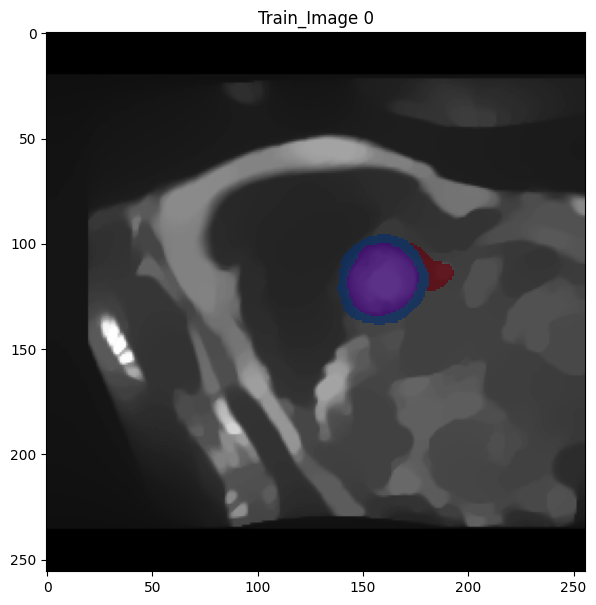

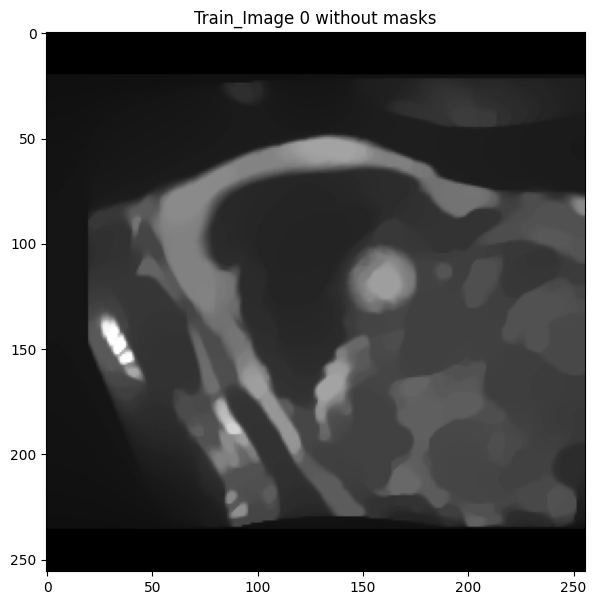

NameError: name 'val_dataset' is not defined

In [62]:
for i in range(3):
    index = np.random.randint(0, len(test_set))
    image = test_set[index]
    print(np.unique(image['mask']))
    visualize_mri_sample(image, "Train_Image " + str(i))
    
    index = np.random.randint(0, len(val_dataset))
    image = val_dataset[index]
    print(np.unique(image['mask']))
    visualize_mri_sample(image, "Val_Image " + str(i))

**Create a dataloader for the corresponding data.**

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

**Visualization of preprocessing impact on 'broken' masks**

In [13]:
# longMasks = []
# for batch in tqdm(train_dataloader):
#     masks = batch['mask']
#     for mask in masks:
#         if len(np.unique(mask)) > 4:
#             mask=mask[0]
#             print(np.unique(mask))
#             mask[np.logical_and(mask>170,mask<255)]=1
#             mask[np.logical_and(mask>3,mask<85)]=2
#             mask[np.logical_and(mask>85,mask<170)]=3
#             print(np.unique(mask))
#             longMasks.append(mask)
# print(longMasks[0].shape)

In [14]:
# print(type(longMasks[0]))
# for mask in longMasks:
#     plt.imshow(mask)
#     plt.show()
#     print(f'       ^^ {np.unique(mask)}')

**The selection of the correct and availble GPUs on the virtual machine.**

In [8]:
def mean(lst):
    return sum(lst) / len(lst)

In [10]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda:4


**Definition of the basic U-net model based on the tutorial.**

In [16]:
# Things to tweak: Kernel size, channels, amt of layers (6 layers only made it worse),
# learning rate, strides (5*2 with 6layers was worse), num res units, batch size, transforms

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function =  monai.losses.DiceLoss(softmax=True, batch=True, to_onehot_y=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm
import wandb
import datetime
# now = datetime.datetime.now() # current date and time
# nu = now.strftime('%c')

# run = wandb.init(
#     project='ACDC_Segmentation',
#     name='BasicTrans_SimpleModel_AllData_',
#     config={
#         'loss function': str(loss_function),
#         'lr': optimizer.param_groups[0]["lr"],
#         'transform': from_compose_to_list(composed_transform),
#         'batch_size': train_dataloader.batch_size,
#         'model': model,
#     }
# )
# # Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# # For example you should add information on your model...

# run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def wandb_masks(mask_output, mask_gt):
    """ Function that generates a mask dictionary in format that W&B requires """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    # sigmoid = torch.nn.Sigmoid()
    # mask_output = sigmoid(mask_output)
    # mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'left-ventricle', 2: 'right-ventricle', 3: 'myocardium'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }
    return masks

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
                mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})

# ⌨️ WRITE YOUR TRAINING LOOP HERE
from tqdm import tqdm

def train_medmnist(model, train_dataloader, val_dataloader, optimizer, epochs, device, val_freq=1):
    train_loss = []
    val_loss = []
    best_dice = -1
    best_loss = 10
    
    for epoch in tqdm(range(epochs)):
        model.train()
        steps = 0
        epoch_loss = 0

        for batch in train_dataloader:
            optimizer.zero_grad()
            images = batch['img'].float().to(device)
            labels = batch['mask'].float().to(device)
            output = model(images)
            loss = loss_function(output, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            steps += 1
            train_ep_loss = epoch_loss/steps
        train_loss.append(epoch_loss/steps)

        # validation loop
        if epoch % val_freq == 0:
            steps = 0
            val_epoch_loss = 0
            model.eval()
            for batch in val_dataloader:
                optimizer.zero_grad()
                images = batch['img'].float().to(device)
                labels = batch['mask'].float().to(device)
                output = model(images)
                loss = loss_function(output, labels)
                val_epoch_loss += loss.item()
                steps += 1
                val_ep_loss = val_epoch_loss/steps

                # ---------- OLD DICE SCORE -----------
                # Run images through inferer and transform for Dice score calculation
                # batch_dices = []
                # inferer = monai.inferers.SimpleInferer()
                # discrete_transform = monai.transforms.AsDiscrete(argmax = True)
                # Softmax = torch.nn.Softmax()
                # diceImages = batch['img'].float().to(device)

#                 for image in diceImages:
#                     with torch.no_grad():
#                         output = discrete_transform(Softmax(model(image).cpu())).squeeze()
#                     dice_mask = np.argmax(output, axis=0)

#                     print(f'dicemask: {np.unique(dice_mask)}, gtmask: {np.unique(labels[i])}')

#                     #Calculate mean Dice score for validation batch
#                     dice = metrics(labels[i], dice_mask)
#                     print(dice)
#                     batch_dices.append(dice)
#                 mean_dice = mean(batch_dices)

                # Save the network if its Dice score is better than the current best
                if val_ep_loss < best_loss:
                    best_loss = val_ep_loss
                    print(f'Best val loss: {best_loss}')
                    torch.save(model.state_dict(), r'ACDC_Best_ROI.pt')

            val_loss.append(val_ep_loss)
        # log_to_wandb(epoch, train_ep_loss, val_ep_loss, batch, output)

    return train_loss, val_loss, model

val_freq = 5
n_epochs = 150

train_loss, val_loss, model = train_medmnist(model, train_dataloader, val_dataloader, optimizer, n_epochs, device, val_freq)

torch.save(model.state_dict(), r'ACDC_Last_ROI.pt')
# run.finish()

  0%|          | 0/150 [00:00<?, ?it/s]

Best val loss: 0.1006772369146347
Best val loss: 0.09917136281728745


  1%|▏         | 2/150 [01:34<1:56:18, 47.15s/it]

In [10]:
# Plot training and validation loss

plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(np.linspace(0, n_epochs, int(n_epochs/val_freq)), val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'train_loss' is not defined

<Figure size 640x480 with 0 Axes>

In [69]:
data_path = "./preprocessed/"
if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "testing"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain training and testing folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [70]:
test_dict = build_dict_ACDC(data_path, mode='testing')
print(len(test_dict))
test_transform = monai.transforms.Compose([
                                           LoadMriData(),
                                           monai.transforms.AddChanneld(keys=['img', 'mask']),
                                           monai.transforms.NormalizeIntensityd(keys=['img']),
                                           # monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
                                           # monai.transforms.Resized(keys = ['img','mask'],spatial_size=(1024,1024), mode=['bilinear','nearest'])
                                            ])
test_set = monai.data.CacheDataset(test_dict, transform=test_transform)
test_loader = monai.data.DataLoader(test_set, batch_size=1)

100%|██████████| 50/50 [00:00<00:00, 262.12it/s]


1076


Loading dataset: 100%|██████████| 1076/1076 [00:14<00:00, 76.26it/s]


In [90]:
roiModel = monai.networks.nets.UNet(
    kernel_size=21,
    up_kernel_size=21,
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

roiModel.load_state_dict(torch.load("trainedUNetROI_Final.pt"))
roiModel.eval()
print("ROI model loaded")

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("ACDC_Best_NewTrans.pt"))
model.eval()
print("Segmentation model loaded")

ROI model loaded
Segmentation model loaded


In [91]:
from skimage.measure import regionprops, label
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
## function for finding the largest connected component and it's centre
## make ROI around centre of size:

# According to Gray’s Anatomy, the heart length, width, and thickness are 12 cm, 8.5 cm, and 6 cm, respectively, doi: 10.15171/jcvtr.2016.25
target_resolution = (1.36719, 1.36719)

def get_ROI(image):
    # Give as an input an image (in the form of a dictionary with labels 'img'and 'mask) 
    # and outputs an ROI centred around the centre of mass of the heart. 
    # Second input is the resolutoin (mm/pixel) of the input image.
    
    # split input into image and mask
    im = image['img']
    mask = image['mask']
    
    # find target size of ROI, based on pixel size (mm/pixel) and maximum expected size of heart (doi: 10.15171/jcvtr.2016.25)
    nr = int(128/2) # number of rows/2
    nc = int(128/2) # number of columns/2

    if len(np.unique(mask))==1:                                            # if there is no heart in the image, just use the central part of the image as an ROI
        labels = label(mask,background=1)                                  # find all connected components
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1    # largest connected components
        mask = largestCC*1                                                 # True --> 1, False --> 0     
        properties = regionprops(mask.astype(int))                         # Geometrical properties of image
        com = np.round(properties[0].centroid).astype(int)                 # Centre of mass = centre of image in this specific case
        com_r = com[0]                                                     # row index
        com_c = com[1]                                                     # column index
        ROI_mask = mask[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)]     # ROI mask
        ROI_mask = 0*ROI_mask
        im = im.squeeze()
        ROI = im[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)]            # ROI of grey scale image
        
    else:                                                                  # if heart is present
        # Find Largest connected component:
        labels = label(mask)                                               # find all connected components
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1    # largest connected components
        largestCC = largestCC*1                                            # True --> 1, False --> 0
        properties = regionprops(largestCC)                                # Geometrical properties of largest connected component
        com = np.round(properties[0].centroid).astype(int)                 # Centre of mass
        com_r = com[0]                                                     # row index
        com_c = com[1]                                                     # column index
        ROI_mask = largestCC[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)]
        im = im.squeeze()
        ROI = im[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)]    
    # plt.figure()
    # plt.imshow(np.squeeze(ROI),'gray')
    # overlay_mask = np.ma.masked_where(ROI_mask==0, ROI_mask)
    # plt.imshow(overlay_mask, 'Reds', alpha = 0.5, clim=[0,1], interpolation='nearest')
    # plt.scatter(x=nc, y=nr, c='g', s=40)
    # plt.figure()
    
    return ROI, com_r, com_c

In [92]:
from medpy.metric.binary import hd, dc
def metrics(img_gt, img_pred, voxel_size):
    """
    Function to compute the metrics between two segmentation maps given as input.
    ----------
    
    Abbreviations:
    ----------
    LV: left ventricle
    RV: right ventricle
    MYO: myocardium
    
    Parameters
    ----------
    img_gt: np.array
    Array of the ground truth segmentation map.  (LV --> class 3, RV --> class 1, myocardium --> class 2)

    img_pred: np.array
    Array of the predicted segmentation map.

    voxel_size: list, tuple or np.array
    The size of a voxel of the images used to compute the volumes (in mm).
    
    For example: for voxels of size 2mm by  1mm by 8mm, use voxel_size = np.array([2 1 8])

    Return
    ------
    A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
    Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
    """

    if img_gt.ndim != img_pred.ndim:
        raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
                         "same dimension, {} against {}".format(img_gt.ndim,
                                                                img_pred.ndim))

    lv = 0
    rv = 0
    myo = 0
    dices = []
    hds = []
    voxel_size = float(voxel_size)
    
    # Loop on each classes of the input images
    for c in [3, 1, 2]:
        # Copy the gt image to not alterate the input
        gt_c_i = np.copy(img_gt)
        gt_c_i[gt_c_i != c] = 0

        # Copy the pred image to not alterate the input
        pred_c_i = np.copy(img_pred)
        pred_c_i[pred_c_i != c] = 0

        # Clip the value to compute the volumes
        gt_c_i = np.clip(gt_c_i, 0, 1)
        pred_c_i = np.clip(pred_c_i, 0, 1)
        
        # Compute the Dice
        dice = dc(pred_c_i, gt_c_i)
        
        # Save the dice score per class
        if c==3:
            lv = dice
        elif c==1:
            rv = dice
        elif c==2:
            myo = dice

        # Append to this list to calculate mean dice
        dices.append(dice)

        # Compute Hausdorff Distance
        hausdorf = hd(pred_c_i, gt_c_i)
        hds.append(hausdorf)

        # Compute volume
        volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
        volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.
        
    return mean(dices), lv, rv, myo, hausdorf, volpred, volpred-volgt

In [93]:
def evaluation(img, mask, seg, model, visual=False):
    """
    Given a model, calculate the dice score of a sample image and ground truth pair.
    Model will be used to create a predicted mask, dice score is calculated between this and ground truth.
    
    If visual=True:
    Allow the visual inspection of one sample by plotting the X-ray image, the ground truth (green)
    and the segmentation map produced by the network (red).
    
    Args:
        sample (Dict[str, torch.Tensor]): sample composed of an X-ray ('img') and a mask ('mask').
        model (torch.nn.Module): trained model to evaluate.
        visual (Boolean): True if you want to see the predicted masks visualized -> will take much longer
    """
    
    # infer output of network
    model.eval()
    inferer = monai.inferers.SimpleInferer()
    Softmax = torch.nn.Softmax()
    
    with torch.no_grad():
        output = Softmax(inferer(sample['img'].float().to(device), network=model).cpu()).squeeze().detach().numpy()
    classes = np.argmax(output, axis=0)  # find class with highest probabillity per pixel
    
    if visual:
        # print(f'For image below, dice = {dice}')
        fig, ax = plt.subplots(1,3, figsize = [12, 10])

        # mask = ground truth segmentation
        mask = np.squeeze(mask)
        
        # create mask for background
        overlay_mask1 = np.ma.masked_where(mask!=1, mask)
        overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
        overlay_mask3 = np.ma.masked_where(mask!=3, mask)

        # Plot MRI image
        ax[0].imshow(img.squeeze(), 'gray')
        ax[0].set_title('Grey scale MRI')

        # Plot ground truth
        ax[1].imshow(img.squeeze(), 'gray')
        ax[1].imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[1].imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[1].imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[1].set_title('Ground truth')

        mask = np.squeeze(seg) # rename (because code for ground truth was copied, and there I named them 'mask' instead of 'classes')
        # select the different components (= value 1, 2 or 3 for myo, LV and RV)
        
        # create mask for background
        overlay_mask1 = np.ma.masked_where(mask!=1, mask)
        overlay_mask2 = np.ma.masked_where(mask!=2 ,mask)
        overlay_mask3 = np.ma.masked_where(mask!=3, mask)

        ax[2].imshow(img.squeeze(), 'gray')
        ax[2].imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[2].imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[2].imshow(overlay_mask3, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
        ax[2].set_title('Prediction')
        plt.show()
    
    return classes

In [94]:
def ac_mask(mask, img):
    '''
    This function applied an active contour model to the segmentation mask.
    It outputs a segmentation mask with 3 classes.
    mask_path: datapath to the mask
    image_path: datapath to the image corresponding to the mask
    '''
    # mask = Image.open(mask_path).convert('L')
    mask = np.array(mask, dtype=np.uint8)
    
    # img = Image.open(img_path).convert('L')
    print(np.unique(img))
    img = np.array(img, dtype=np.uint8)
    print(np.unique(img))
    # print(img.shape)
    # plt.imshow(img)
    # plt.show()
    
    nx, ny = mask.shape
    
    # Find boundaries of each mask
    init = mask*find_boundaries(mask, mode='inner')
    init_1 = init*(init == 1)
    init_2 = init*(init == 2)
    init_3 = init*(init == 3)
    
    # Mask 1
    # Find coordinates of boundary
    indeces1 = np.where(init_1 == 1)
    xy_coords1 = np.column_stack(indeces1)
    
    # Apply AC
    snake1 = active_contour(img,
                       xy_coords1, alpha=0.015, beta=10, gamma=0.000001, w_line=-1)
    
    new_mask1 = np.zeros((nx, ny))
    
    # Build new boundary from snake coordinates
    for i, j in snake1:
        new_mask1[int(i), int(j)] = 1
    
    # Fill the mask
    new_mask1 = binary_fill_holes(new_mask1)
    
    # Mask 2
    # Find coordinates of boundary
    indeces2 = np.where(init_2 == 2)
    xy_coords2 = np.column_stack(indeces2)
    
    # Apply AC
    snake2 = active_contour(img,
                       xy_coords2, alpha=0.015, beta=10, gamma=0.000001, w_line=-1)
    
    new_mask2 = np.zeros((nx, ny))
    
    # Build new boundary from snake coordinates
    for i, j in snake2:
        new_mask2[int(i), int(j)] = 1
    
    # Fill the mask
    new_mask2 = binary_closing(new_mask2, structure=np.ones((10,10)))
    
    # Set to right class
    new_mask2 = new_mask2*2
    
    # Mask 3
    # Find coordinates of boundary
    indeces3 = np.where(init_3 == 3)
    xy_coords3 = np.column_stack(indeces3)
    
    # Apply AC
    snake3 = active_contour(img,
                       xy_coords3, alpha=0.015, beta=10, gamma=0.0000001, w_line=-1)
    
    new_mask3 = np.zeros((nx, ny))
    
    # Build new boundary from snake coordinates
    for i, j in snake3:
        new_mask3[int(i), int(j)] = 1

    # Fill the mask
    new_mask3 = binary_fill_holes(new_mask3)
    
    # Set to right class
    new_mask3 = new_mask3*3
    
    # Combine mask 1 and 2
    new_mask = new_mask1+new_mask2
    
    # If they overlap, choose mask 2
    new_mask[new_mask == 3] = 2
    
    # Add mask 3
    new_mask = new_mask+new_mask3
    
    # If they overlap, choose mask 3
    new_mask[new_mask > 3] = 3
    
    return new_mask

In [157]:
dices = []
lvs = []
rvs = []
myos = []
hds = []
volpreds = []
volerrors = []
best_dice = 0
worst_dice = 10
current_patient = ''
initialize = False

for i, sample in enumerate(tqdm(test_loader)):
    # Get ROI
    inferer = monai.inferers.SimpleInferer()
    discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    addchannel = monai.transforms.AddChannel()
    norm = monai.transforms.NormalizeIntensity()
    Sigmoid = torch.nn.Sigmoid()
    
    # Denoise an image
    inputImage = denoise_tv_chambolle(sample['img'].cpu().detach().numpy(), eps=1e-6, weight=0.1, max_num_iter=1000)
    inputImage = torch.from_numpy(inputImage)
    
    # Use this instead of 2 lines above if data is already denoised
    # inputImage = sample['img']
    
    with torch.no_grad():
        roiOutput = discrete_transform(Sigmoid(inferer(inputImage.float().to(device), network=roiModel).cpu())).squeeze().detach().numpy()
    
    roiDict = {'img': sample['img'], 'mask': roiOutput}
    nr = nc = int(128/2)
    ROI, com_r, com_c = get_ROI(roiDict)
    
    # Get segmentation on ROI
    Softmax = torch.nn.Softmax()
    with torch.no_grad():
        output = Softmax(inferer(torch.from_numpy(np.resize(addchannel(ROI), (1,1,128,128))).float().to(device), network=model).cpu()).squeeze().detach().numpy()

    seg = np.argmax(output, axis=0)
    img = sample['img'].squeeze()[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)]
    mask = sample['mask'].squeeze()[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)]
    
    # evaluation(img, mask, seg, model, visual=True)
    
    # Place segmented ROI back in full image size
    finalseg = np.zeros((256,256))
    finalseg[(com_r-nr):(com_r+nr),(com_c-nc):(com_c+nc)] = seg
    seg = finalseg
    
    # ---- ROI done ----
    
    # Initialize empty masks once
    mask = sample['mask'].squeeze().numpy()
    
    # Get voxel_size and patient from file names
    voxel_size = test_dict[i]['mask'].split('_')[-2]
    
    # Do 0 + (i*1) to the split index, where 'i' is amount of underscores in folder name
    patient = test_dict[i]['img'].split('_')[0][-10:]
    
    # Make image with correct dimensions for AC model
    acImg = sample['img'].squeeze()
    
    # If first patients, initialize (3D) arrays
    if ('patient101' in patient or 'patient001' in patient) and not initialize:
        best_seg = np.zeros(mask.shape)
        worst_seg = np.zeros(mask.shape)
        threedmask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        threedsample = acImg.reshape(acImg.shape[0], acImg.shape[1], 1)
        
        # plt.imshow(sample['img'].squeeze())
        # plt.title('sample')
        # plt.show()
        # seg = ac_mask(seg, acImg)
        
        threedseg = seg.reshape(seg.shape[0], seg.shape[1], 1)
        current_patient = patient
        initialize = True
    # If patient is new, but not the first patient
    elif patient not in current_patient:
        # ----- Calculate all metrics on 3D-mask -----
        
        # Hacky fix for classes being mixed up with a certain model
        threedseg[threedseg==1]=4
        threedseg[threedseg==2]=5
        threedseg[threedseg==3]=6
        threedseg[threedseg==4]=3
        threedseg[threedseg==5]=1
        threedseg[threedseg==6]=2
        
        dice, lv, rv, myo, haus, volpred, volerror = metrics(threedmask, threedseg, voxel_size)
        print(dice)
        lvs.append(lv)
        rvs.append(rv)
        myos.append(myo)
        volpreds.append(volpred)
        volerrors.append(volerror)
        
        if dice > best_dice:
            best_seg = threedseg[:,:,5]
            best_dice = dice
            
            best = Image.fromarray(best_seg.astype('uint8'))
            best.save("BestSegmentation_seg.png")
            
            save_image(torch.from_numpy(threedsample[:,:,5])*255, 'BestSegmentation_img.png', normalize=True)
            
            save_image(torch.from_numpy(threedmask[:,:,5]).double(), 'BestSegmentation_mask.png', normalize=False)
        elif dice < worst_dice:
            worst_seg = threedseg[:,:,5]
            worst_dice = dice
            
            worst = Image.fromarray(worst_seg.astype('uint8'))
            worst.save("WorstSegmentation_seg.png", format='PNG')
            
            save_image(torch.from_numpy(threedsample[:,:,5])*255, 'WorstSegmentation_img.png', normalize=True)
            
            save_image(torch.from_numpy(threedmask[:,:,5]).double(), 'WorstSegmentation_mask.png', normalize=False)
        dices.append(dice)
        hds.append(haus)
        
        # Reset 3D arrays
        threedsample = acImg.reshape(acImg.shape[0], acImg.shape[1], 1)
        threedmask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        threedseg = seg.reshape(seg.shape[0], seg.shape[1], 1)
        current_patient = patient
    # If same patient, add current mask to the 3D mask
    elif patient in current_patient:
        # Make mask&seg fit 3D shape
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        
        # plt.imshow(sample['img'].squeeze())
        # plt.title('sample')
        # plt.show()
        # seg = ac_mask(seg, acImg)
        sample = acImg.reshape(acImg.shape[0], acImg.shape[1], 1)
        seg = seg.reshape(seg.shape[0], seg.shape[1], 1)
        
        # Concatenate in 3rd dimension
        threedsample = np.concatenate((threedsample, sample), 2)
        threedmask = np.concatenate((threedmask, mask), 2)
        threedseg = np.concatenate((threedseg, seg), 2)

meanlv = mean(lvs)
meanrv = mean(rvs)
meanmyo = mean(myos)
meandice = mean(dices)
meanhd = mean(hds)
meanvolpred = mean(volpreds)
meanvolerror = mean(volerrors)

print(f'Total mean Dice: {meandice}, mean Dice LV: {meanlv}, mean Dice RV: {meanrv}, mean Dice Myo: {meanmyo}, mean Hausdorff: {meanhd}, mean Volume error: {meanvolerror}')

  0%|          | 0/1076 [00:00<?, ?it/s]/home/jovyan/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
/tmp/ipykernel_58923/77099441.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = Softmax(inferer(torch.from_numpy(np.resize(addchannel(ROI), (1,1,128,128))).float().to(device), network=model).cpu()).squeeze().detach().numpy()
  2%|▏         | 21/1076 [00:03<07:11,  2.45it/s]

0.8790449982415464


  4%|▎         | 38/1076 [00:06<04:18,  4.02it/s]

0.9168177740238773


  5%|▌         | 55/1076 [00:09<06:47,  2.51it/s]

0.8323531695065546


  7%|▋         | 73/1076 [00:14<06:12,  2.70it/s]

0.8192209693969827


  9%|▉         | 95/1076 [00:17<03:00,  5.43it/s]

0.8816436445904473


 10%|█         | 111/1076 [00:19<04:49,  3.33it/s]

0.6661732814264707


 12%|█▏        | 130/1076 [00:27<05:37,  2.80it/s]

0.7616812317345846


 14%|█▍        | 149/1076 [00:30<07:12,  2.14it/s]

0.7726233417274062


 16%|█▌        | 167/1076 [00:36<03:45,  4.02it/s]

0.8031042573701009


 17%|█▋        | 184/1076 [00:38<03:43,  4.00it/s]

0.8450410865978452


 18%|█▊        | 196/1076 [00:40<02:51,  5.12it/s]

0.8488731437702356


 20%|█▉        | 215/1076 [00:43<06:13,  2.30it/s]

0.8122402364908491


 22%|██▏       | 236/1076 [00:48<03:58,  3.53it/s]

0.7772944824851545


 24%|██▍       | 258/1076 [00:51<03:55,  3.48it/s]

0.6221441295640573


 26%|██▌       | 278/1076 [00:56<06:57,  1.91it/s]

0.8980528826221877


 28%|██▊       | 298/1076 [00:59<03:45,  3.45it/s]

0.8943480148313424


 30%|██▉       | 319/1076 [01:02<02:39,  4.75it/s]

0.6575907320770944


 31%|███       | 335/1076 [01:05<03:22,  3.66it/s]

0.8657772379130355


 34%|███▍      | 369/1076 [01:14<06:39,  1.77it/s]

0.8650797010949285


 36%|███▌      | 387/1076 [01:21<07:56,  1.45it/s]

0.7453139139210317


 38%|███▊      | 404/1076 [01:25<03:59,  2.81it/s]

0.8002075832584307


 39%|███▉      | 422/1076 [01:28<02:48,  3.88it/s]

0.82114059706031


 41%|████      | 437/1076 [01:31<05:04,  2.10it/s]

0.8807582929033851


 45%|████▍     | 481/1076 [01:46<05:30,  1.80it/s]

0.8241122546391345


 48%|████▊     | 513/1076 [01:55<06:00,  1.56it/s]

0.8342546454134953


 51%|█████     | 545/1076 [02:09<06:34,  1.35it/s]

0.7927731641749581


 54%|█████▍    | 584/1076 [02:23<03:51,  2.13it/s]

0.8465921600709153


 56%|█████▌    | 602/1076 [02:26<02:00,  3.92it/s]

0.8816781756088009


 59%|█████▉    | 636/1076 [02:31<02:56,  2.50it/s]

0.8028716328613381


 61%|██████    | 656/1076 [02:34<01:30,  4.64it/s]

0.8170601694486342


 63%|██████▎   | 677/1076 [02:37<01:13,  5.40it/s]

0.7690151001392055


 65%|██████▍   | 696/1076 [02:40<01:17,  4.92it/s]

0.8057716022901839


 67%|██████▋   | 716/1076 [02:43<02:03,  2.93it/s]

0.6732092150440487


 69%|██████▊   | 738/1076 [02:47<01:43,  3.28it/s]

0.9082340320551664


 70%|███████   | 758/1076 [02:51<01:29,  3.56it/s]

0.6777617972154992


 72%|███████▏  | 779/1076 [02:54<01:06,  4.47it/s]

0.8366901698689663


 74%|███████▍  | 797/1076 [02:56<00:47,  5.87it/s]

0.8125197524649419


 76%|███████▌  | 815/1076 [03:02<01:29,  2.91it/s]

0.8529650270206931


 79%|███████▊  | 847/1076 [03:08<01:02,  3.69it/s]

0.9022208692660821


 82%|████████▏ | 886/1076 [03:15<01:15,  2.53it/s]

0.6726665989811292


 84%|████████▍ | 906/1076 [03:19<00:53,  3.21it/s]

0.8716906496498055


 86%|████████▌ | 922/1076 [03:22<00:44,  3.44it/s]

0.8371770039200946


 88%|████████▊ | 942/1076 [03:24<00:35,  3.80it/s]

0.8553013768328487


 89%|████████▉ | 958/1076 [03:27<00:23,  5.12it/s]

0.8775072126008668


 91%|█████████ | 978/1076 [03:30<00:25,  3.81it/s]

0.771052763619041


 93%|█████████▎| 996/1076 [03:33<00:24,  3.26it/s]

0.8572939913226589


 95%|█████████▌| 1025/1076 [03:38<00:25,  1.98it/s]

0.7848901653094619


 97%|█████████▋| 1042/1076 [03:42<00:11,  3.09it/s]

0.8781954416557435


 99%|█████████▉| 1063/1076 [03:46<00:03,  3.44it/s]

0.8737005405023307


100%|██████████| 1076/1076 [03:48<00:00,  4.70it/s]

Total mean Dice: 0.8159944941751818, mean Dice LV: 0.8814097259744874, mean Dice RV: 0.7939229587241872, mean Dice Myo: 0.7726507978268703, mean Hausdorff: 12.673261127478662, mean Volume error: -60.07330929568075


In [101]:
print('Lets see the results...')

Lets see the results...
